In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M-q-BE0Jffs8X0WsAJmgHW28QtYLhp3E&confirm=t&uuid=2f587c8b-4a2d-4f68-bbbb-19a19e5cec7e&at=AD1-pjEbrMTXSHSgfyvDWO3CEhwa:1674725134127' -O dataset.zip
#!mv dataset.zip "/content/drive/MyDrive/Colab Notebooks/Data"

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Data/dataset.zip"
!unzip "/content/drive/MyDrive/Colab Notebooks/Data/extra_dataset.zip"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn

from tqdm.auto import tqdm

In [5]:
import random


def fix_random_seed(seed=None):
    """Fix all random seeds."""
    seed = seed or random.randint(0, 14300631)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"All random seeds are set to {seed}.")

In [6]:
SEED = 179
fix_random_seed(SEED)

All random seeds are set to 179.


In [7]:
!pip install wcmatch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from wcmatch import glob

train_paths = glob.glob(["./train/**/*.png", './train/**/**/*.jpg'])
train_labels = [path.split('/')[2] for path in train_paths]

val_paths = glob.glob("./valid/**/*.png")

val_labels = [path.split('/')[2] for path in val_paths]

In [9]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, paths, transforms):
        super().__init__()
        self.paths = sorted(paths)
        self.transforms = transforms
        
        self.labels = [path.split('/')[2] for path in self.paths]
        self.classes = np.unique(self.labels).tolist()
        self.label2id = {class_: idx for idx, class_ in enumerate(self.classes)}
        self.id2label = {idx: class_ for idx, class_ in enumerate(self.classes)}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        with Image.open(self.paths[idx]) as im:
                if im.mode != "RGB":
                    im = im.convert("RGB")
                else:
                    im.load()
                sample = self.transforms(im)
        label = self.label2id[self.labels[idx]]
        return sample, label

In [10]:
import torchvision.transforms as T

base_transforms = T.Compose([
    T.ToTensor(),
    T.Resize(size=(224, 224)),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
trainset = ImageDataset(train_paths, transforms=base_transforms)
valset = ImageDataset(val_paths, transforms=base_transforms)

In [11]:
def show_six_random_samples(dataset):
    sample_ids = np.random.choice(len(dataset), 6)
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = [ax for ax_row in axes for ax in ax_row]
    for sample_id, ax in zip(sample_ids, axes):
        sample, label_id = dataset[sample_id]
        label = dataset.id2label[label_id]
        array = 0.5 * sample.permute(1, 2, 0).numpy() + 0.5
        ax.imshow(array)
        ax.set_title(f"{label} ({label_id = }) [{array.shape[0]} x {array.shape[1]}]")
        # отключаем координатную сетку
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [12]:
from sklearn.metrics import classification_report


def eval_model(model, dataloader, criterion, device, classes, make_report=False):
    model = model.to(device)
    scores, ground_truth = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images).to(device)
            scores.append(logits)
            ground_truth.append(labels)
        scores = torch.cat(scores)
        ground_truth = torch.cat(ground_truth)
        ground_truth_dim2 = nn.functional.one_hot(ground_truth, num_classes=2).to(device)
        loss = criterion(scores.float(), ground_truth_dim2.float()).item()
        predictions = torch.argmax(scores, dim=1)
        accuracy = (predictions == ground_truth).sum().item() / ground_truth.size(0)
    if make_report:
        predictions = predictions.cpu().numpy()
        ground_truth = ground_truth.cpu().numpy()
        report = classification_report(ground_truth, predictions, target_names=classes, zero_division=0)
    else:
        report = None
    return loss, accuracy, report

In [13]:
def unfreeze_layer(model, epoch, parameters_per_epoch):
  parametres_list = list(model.parameters())
  for i in range(epoch*parameters_per_epoch, (epoch+1)*parameters_per_epoch):
    if i < len(parametres_list):
      parametres_list[i].requires_grad=True
    else:
      break

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, classes, scheduler=None, fine_tuning=True, save_weights = True):
    history = []
    model = model.to(device)
    if fine_tuning:
      layers_count = len(list(model.parameters()))
      for par in model.parameters():
        par.requires_grad=False
    with tqdm(total=epochs, desc='Epoch') as epoch_pbar:
        for _ in range(epochs):
            if fine_tuning:
              unfreeze_layer(model, _, layers_count // epochs + 1)
            running_loss = 0
            running_corrects = 0
            running_data = 0
            model.train()
            with tqdm(total=len(train_loader), desc='Batch', leave=False) as batch_pbar:
                for batch_count, (images, labels) in enumerate(train_loader, 1):
                    images = images.to(device)
                    labels = nn.functional.one_hot(labels, num_classes=2).to(device)
                    # optimization part
                    optimizer.zero_grad()
                    logits = model(images).to(device)

                    loss = criterion(logits.float(), labels.float())

                    loss.backward()
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()
                    # calculate metrics
                    running_loss += loss.item()
                    predicts = torch.argmax(logits, dim=1)
                    predicts = nn.functional.one_hot(predicts, num_classes=2).to(device)
                    running_data += images.size(0)
                    running_corrects += (predicts == labels).sum().item()//2
                    # save metrics history
                    history.append({'train_loss': loss.item(), 'train_acc': running_corrects / running_data})
                    # update progress bar
                    batch_pbar.set_postfix(loss=running_loss / batch_count, acc=running_corrects / running_data)
                    batch_pbar.update()
            
            val_loss, val_acc, _ = eval_model(model, val_loader, criterion, device, classes)
            history[-1]['val_loss'] = val_loss
            history[-1]['val_acc'] = val_acc
            epoch_pbar.set_postfix(
                train_loss=running_loss / len(train_loader),
                val_loss=val_loss,
                train_acc=history[-1]['train_acc'],
                val_acc=val_acc,
            )
            
            epoch_pbar.update()
            if save_weights:
                path = f"model-save-{len(history)}e"
                torch.save(model.state_dict(), path)
                torch.save(model.state_dict(), "model-last")
                !mv "model-last" "/content/drive/MyDrive/Colab Notebooks/Data"
    return pd.DataFrame(history)

In [15]:
def predict(model, dataloader, device):
    model = model.to(device)
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc='Predicting'):
            logits = model(images.to(device))
            predictions.append(torch.argmax(logits, dim=1).cpu().numpy())
    return np.concatenate(predictions)

In [16]:
from torch.utils.data import DataLoader

val_loader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

device = torch.device('cuda:0')

In [17]:
logits = [ len(trainset.labels)/trainset.labels.count('real'), len(trainset.labels)/trainset.labels.count('spoof')]

In [18]:
logits = torch.tensor(logits).to(device)

In [19]:
criterion = nn.BCEWithLogitsLoss(pos_weight=logits)

In [20]:
experiments = {} 

In [21]:
def predict(model, dataloader, device):
    model = model.to(device)
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc='Predicting'):
            logits = model(images.to(device))
            predictions.append(torch.argmax(logits, dim=1).cpu().numpy())
    return np.concatenate(predictions)

# Константы

In [29]:
IN_CHANNELS = 3
N_CLASSES = 2
LR = 1e-3
EPOCHS = 10

# Аугментация

In [23]:
augmentation = T.Compose([
    T.ToTensor(),
    T.RandomAffine(degrees=(-15, 15), translate=(0.1, 0.2)),
    T.Resize(size=(224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomHorizontalFlip(p=0.5)
])

In [24]:
trainset.transforms = augmentation

# Модель

In [25]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, pin_memory=True)

In [26]:
import torchvision

In [27]:
model = torchvision.models.mobilenet_v3_large(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 61.5MB/s]


In [28]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=N_CLASSES, bias=True),
    nn.Sigmoid()
)

## Classifier training

In [30]:
CLASSIFIER_EPOCHS = 2

In [31]:
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.2 * LR, total_steps=CLASSIFIER_EPOCHS* len(train_loader))
train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer=optimizer,
    epochs=CLASSIFIER_EPOCHS,
    device=device,
    classes=trainset.classes,
    scheduler=scheduler,
    fine_tuning=False,
    save_weights=False
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

,train_loss,train_acc,val_loss,val_acc
0,0.955954,0.437500,NaN,NaN
1,0.941280,0.460938,NaN,NaN
2,0.958091,0.541667,NaN,NaN
3,0.957414,0.582031,NaN,NaN
4,0.929481,0.617188,NaN,NaN
...,...,...,...,...
323,0.670173,0.964209,NaN,NaN
324,0.685236,0.964286,NaN,NaN
325,0.676035,0.964410,NaN,NaN
326,0.684267,0.964388,NaN,NaN


## Model Training

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.2 * LR, total_steps=EPOCHS* len(train_loader))
experiments = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    classes=trainset.classes,
    scheduler=scheduler,
    fine_tuning=True,
    save_weights=True
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/164 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

In [33]:
def plot_experiments(experiments):
    fig, axes = plt.subplots(2, 2, figsize=(25, 13))
    axes = [ax for ax_row in axes for ax in ax_row]
    for name, history in experiments:
        for metric, ax in zip(history.columns, axes):
            marker = 'o' if metric.startswith('val_') else None
            history[metric].dropna().plot(ax=ax, label=name, marker=marker)
    for metric, ax in zip(history.columns, axes):
        ax.set_title(f'{metric} history')
        ax.set_xlabel('Iteration (batch)')
        ax.legend()
    plt.show()

In [34]:
history = {'mobilenet with finetuning': experiments}

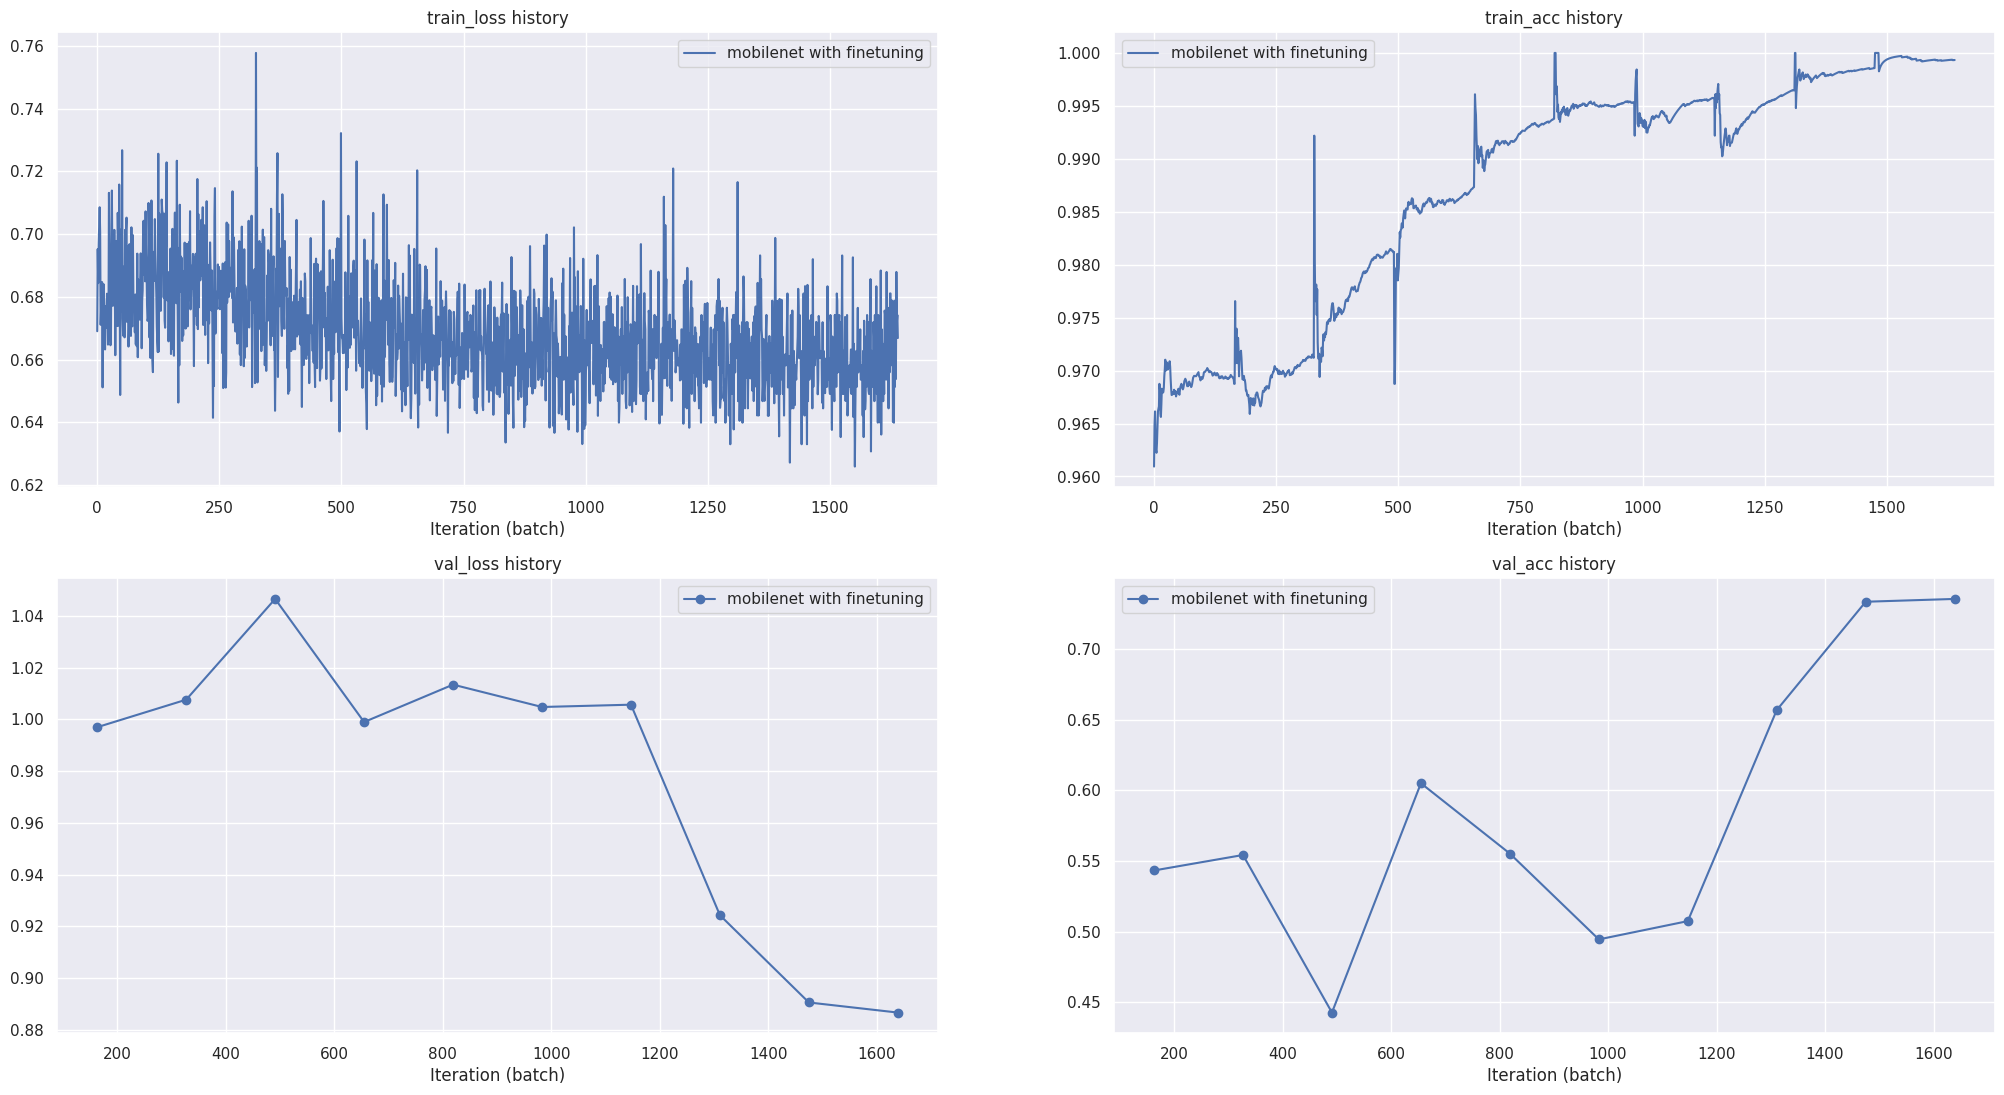

In [35]:
plot_experiments(history.items())

In [36]:
torch.save(model.state_dict(), "model-mobilenet")

In [38]:
!mv "model-mobilenet" "/content/drive/MyDrive/Colab Notebooks/Data"

# Test

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Data/test_custom.zip"

In [68]:
test_paths = glob.glob('./test_custom/*/*')
test_labels = [path.split('/')[2] for path in train_paths]

testset = ImageDataset(test_paths, base_transforms)

In [70]:
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

In [71]:
_, _, report = eval_model(model, test_loader, criterion, device, testset.classes, make_report=True)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [72]:
print(report)

              precision    recall  f1-score   support

        real       0.35      0.42      0.39        40
       spoof       0.71      0.65      0.68        88

    accuracy                           0.58       128
   macro avg       0.53      0.54      0.53       128
weighted avg       0.60      0.58      0.59       128

